In [3]:
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

print(tfp.__version__)
print(tf.__version__)
print(np.__version__)
print(pd.__version__)

0.14.0
2.7.0
1.21.6
1.4.2


In [12]:
tfd = tfp.distributions
tfpl = tfp.layers

### lets create some training data by the following equation

$$
y_i = \mathcal{f}(x_i) = x_i + \frac{3}{10}\epsilon _i,
$$

where $$ \epsilon _i \sim \mathcal{N}(0, 1) $$

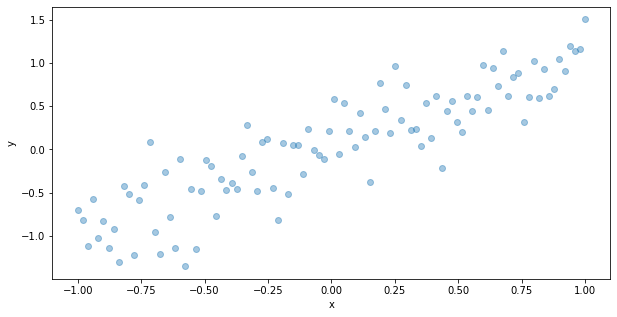

In [2]:
x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### lets do linear least squares

In [4]:
model = Sequential([
    Dense(units=1, input_shape=(1,))
])
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


2022-07-04 14:55:58.904610: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


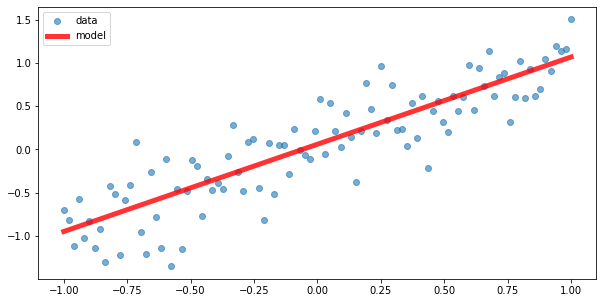

In [11]:
# plot the trained model and data
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, alpha=0.6, label='data')
plt.plot(x_train, model.predict(x_train), color='red', alpha=0.8, label='model', linewidth=5)
plt.legend()
plt.show()

### lets do probabilistic linear regression instead

In [17]:
# lets create a new model with a normal distributed final layer
model_prob = Sequential([
    Dense(units=1, input_shape=(1, )),
    tfpl.DistributionLambda(lambda t : tfd.Independent(distribution=tfd.Normal(loc=t, scale=1)))
])
model_prob.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
 distribution_lambda_3 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [16]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)


In [26]:
model_prob.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model_prob.fit(x_train, y_train, epochs=100, verbose=False)

In [27]:
# examine the feed forward
x = np.array([[0]])
y_model = model_prob(x)
y_model

<tfp.distributions._TensorCoercible 'sequential_4_distribution_lambda_3_tensor_coercible' batch_shape=[1] event_shape=[1] dtype=float32>

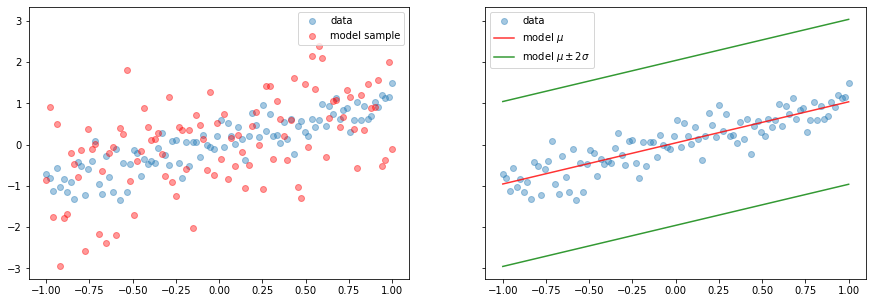

In [28]:
y_model = model_prob(x_train)
y_sample = y_model.sample()
# since y_model is a distribution we have access to the mean and std
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()


In [25]:
# in this case we have only parameterized the mean, lets make a model to parameterize the standard deviation also

# units has to be 2 since we are trying to estimate both the mean and the std
model_prob2 = Sequential([
    Dense(units=2, input_shape=(1, )),
    tfpl.DistributionLambda( lambda t : tfd.Independent(distribution=tfd.Normal(
        loc=t[..., 0:1], scale=tf.math.softplus(t[..., 1:2]) # [..., 0:1] -> first event dimension [..., 1:2] -> second event dimension
    )))
])

# the model above can be written more compressed using event shape and static method for parameter size
event_shape = 1
model_prob3 = Sequential([ 
    Dense(units=tfpl.IndependentNormal.params_size(event_shape=event_shape), input_shape=(1,)),
    tfpl.IndependentNormal(event_shape)
])


model_prob2.summary()
model_prob3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 2)                 4         
                                                                 
 distribution_lambda_6 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 2)                 4         
                                                                 
 independent_normal_1 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1

In [30]:
# model_prob2 and model_prob3 are equal so running only one of them
model_prob2.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model_prob2.fit(x_train, y_train, epochs=200, verbose=False)

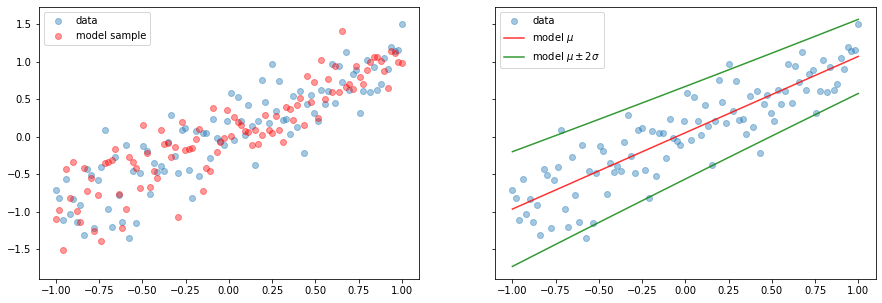

In [31]:
y_model = model_prob2(x_train)
y_sample = y_model.sample()
# since y_model is a distribution we have access to the mean and std
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

### lets learn a non-linear mean and variance from the equation


$$
y_i = \mathcal{f}(x_i) = x_i ^3 - 0.2 + \frac{1}{10} (2 + x_i) \epsilon _i,
$$

where $$ \epsilon _i \sim \mathcal{N}(0, 1) $$

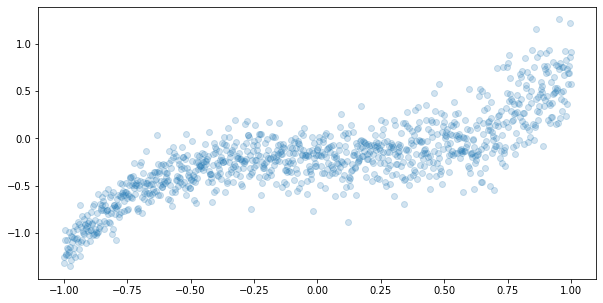

In [40]:
x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) - 0.2 + 0.1 * ( x_train + 2 ) * np.random.randn(1000)[:, np.newaxis]

plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, alpha=0.2)
plt.show()

In [81]:
event_shape = 1
model_prob_nonlin = Sequential([
    Dense(units=32, input_shape=(1, ), activation='tanh',
    kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.5),
    bias_initializer=tf.constant_initializer(0.0)
    ),
    Dense(units=tfpl.IndependentNormal.params_size(event_shape=event_shape)),
    tfpl.IndependentNormal(event_shape=event_shape)
]) 
model_prob_nonlin.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 32)                64        
                                                                 
 dense_29 (Dense)            (None, 2)                 66        
                                                                 
 independent_normal_11 (Inde  ((None, 1),              0         
 pendentNormal)               (None, 1))                         
                                                                 
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________


In [114]:
model_prob_nonlin.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model_prob_nonlin.fit(x_train, y_train, epochs=1600, verbose=False)

In [115]:
model_prob_nonlin.evaluate(x_train, y_train)

32/32 [==============================] - 0s 287us/step - loss: -0.2042


-0.20423142611980438

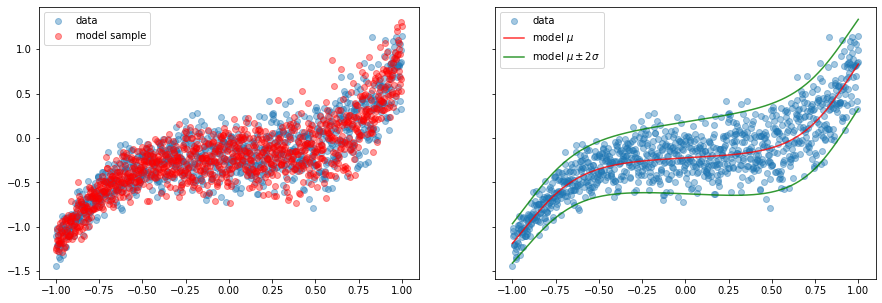

In [116]:
y_model = model_prob_nonlin(x_train)
y_sample = y_model.sample()
# since y_model is a distribution we have access to the mean and std
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

### lets try a linear model with basis expansion on the form


$$
y_i = \mathcal{f}(x_i) = \beta _3 x_i ^3 + \beta _2 x_i ^2 + \beta _1 x_i + \beta _0 1
$$


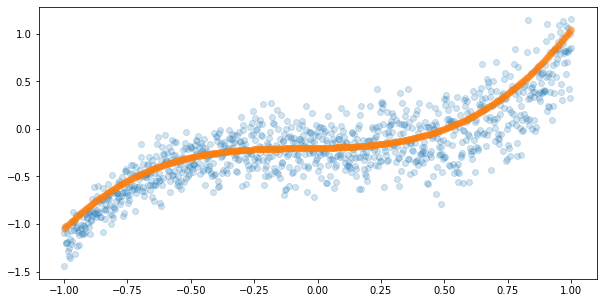

In [122]:
# lets see how we can fit the basis expanded with some manually tweeked parameters

x_train_bexp = np.stack((x_train[:,0]**3 , x_train[:,0]**2, x_train[:,0], np.ones([1000])), axis=1 ) 
y_rand = x_train_bexp.dot(np.array([1, 0.2, 0.05, -0.2]))

plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, alpha=0.2)
plt.scatter(x_train, y_rand, alpha=0.2)
plt.show()

# ***abit cheeting since we know the data points are created by a third degree equation with parameter beta_3 = 1


In [123]:
# now lets create a probabilistic model with the basis expansion

event_shape = 1
model_bexp = Sequential([
    Dense(units=1, input_shape=(4, ), activation='linear',
    kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.1),
    use_bias=False
    ),
    Dense(units=tfpl.IndependentNormal.params_size(event_shape=event_shape)),
    tfpl.IndependentNormal(event_shape=event_shape)
]) 
model_bexp.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 1)                 4         
                                                                 
 dense_33 (Dense)            (None, 2)                 4         
                                                                 
 independent_normal_13 (Inde  ((None, 1),              0         
 pendentNormal)               (None, 1))                         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [124]:
model_bexp.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model_bexp.fit(x_train_bexp, y_train, epochs=1600, verbose=False)

In [125]:
model_bexp.evaluate(x_train_bexp, y_train)

32/32 [==============================] - 0s 318us/step - loss: -0.1839


-0.18386976420879364

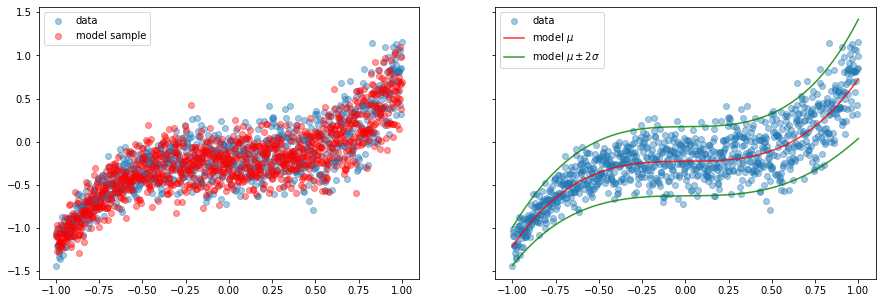

In [126]:
y_model = model_bexp(x_train_bexp)
y_sample = y_model.sample()
# since y_model is a distribution we have access to the mean and std
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()